# Install Packages

In [1]:
import sys, os, pdb
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table, join
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import csv

# Define Functions

In [2]:
def calc_KME(region, mdust, e_mdust, ddet):

   """
   PURPOSE:    Calculate the KME

   INPUT:      region = region name (str)
               mdust = dust mass (array of floats)
               mdust = dust mass errors (array of floats)
               ddet = detection flag; 1=detected, 0=undetected (array of floats)

   OUTPUT:     KME output for plotting

   """
   
   ### REPLACE NON-DETECTIONS WITH 3-SIGMA UPPER LIMITS
   mdust[ddet == 0] = 3.0 * e_mdust[ddet == 0]
   
   dfrac = float(len(ddet[ddet==1]) )/ len(ddet)
   kmf = KaplanMeierFitter()
   kmf.fit(mdust, ddet)
   
   k = kmf.survival_function_
   x = np.array(k.index)
   y = dfrac * np.array(k.values[:,0])
   
   kc = kmf.confidence_interval_
   yu = dfrac * kc.values[:,0]
   yl = dfrac * kc.values[:,1]
   
   print('\n>>> ' + region)
   print('     median = {0:.2f} '.format(dfrac * kmf.median_survival_time_))
   print('     mean   = {0:.2f} '.format(np.trapz(y, x=x)))
   
   return x, y, yu, yl

In [3]:
def read_asurv_output(asurv_file):

   """
    PURPOSE:    Read in output of ASURV KME calculation
    INPUT:      ASURV KME output file
    OUTPUT:     KME output for plotting

    """
   
   ### READ IN FILE LINE-BY-LINE
   print("\nReading in " + asurv_file + "...\n")
   with open(asurv_file) as f:
      lines = f.readlines()
   lines = np.array(lines)
    
   ### GET LINES WITH KME INFO
   temp = np.array([''])
   for i, val in enumerate(lines):

      if (lines[i][0:4] == 'FROM'):
         temp = np.append(temp,lines[i])

      if (lines[i][0:19] == '        PERCENTILES'):
         print(lines[i],lines[i+1],lines[i+2],lines[i+3],lines[i+4])
         kme_med = "{0:.2f}".format(float((lines[i+2][18:26]).replace(" ", "")))
         kme_mean = (lines[i+4][14:34]).replace(" ", "").split('+/-')
         kme_mean[0] = "{0:.2f}".format(float(kme_mean[0]))
         kme_mean[1] = "{0:.2f}".format(float(kme_mean[1]))

   temp[-1] = temp[-1].replace("ONWARDS    ","TO  "+temp[-1][6:13],1)
   temp[1]  = temp[1][:-2] + '        0.00 \n'
   
   ### WRITE TO TEMPORARY FILE
   f = open('temp.txt','w')
   f.writelines(list(temp))
   f.close()
    
   ### READ BACK
   kme = np.genfromtxt('temp.txt',dtype={'names':   ('c1','bin_start','c2','bin_end','kme','err'),
                                         'formats': ('S20',float,'S20',float,float,float)})
   os.system('rm temp.txt')

   ### CLEANUP
   kme = Table(kme)
   kme.keep_columns(['bin_start','bin_end','kme','err'])
   kme['cdf'] = 1.0 - kme['kme']
   kme['bin_ctr'] = kme['bin_start'] + (kme['bin_end']-kme['bin_start'])/2.0

   return kme, kme_mean, kme_med

# Code

NOTE: The original paper uses outputs from ASURV to create this figure. Those outputs have been made available at data/ASURV and are used in the following code to exactly recreate the figures. The ASURV calculations and outputs can be approximated by using linmix instead. The code for linmix is provided at the bottom.

### ASURV Version (original)

Load in data

In [4]:
kme_lup, mean_lup, med_lup = read_asurv_output('../data/ASURV/lup_d.out')
kme_tau, mean_tau, med_tau = read_asurv_output('../data/ASURV/tau_d.out')
kme_usc, mean_usc, med_usc = read_asurv_output('../data/ASURV/usc_d.out')
kme_sor, mean_sor, med_sor = read_asurv_output('../data/ASURV/sor_d.out')
kme_cha, mean_cha, med_cha = read_asurv_output('../data/ASURV/cha_d.out')


Reading in ../data/ASURV/lup_d.out...

        PERCENTILES    
          75 TH     50 TH     25 TH
           0.798     3.314    12.484
     
         MEAN=    15.046 +/- 3.270   LIMITED TO      0.127


Reading in ../data/ASURV/tau_d.out...

        PERCENTILES    
          75 TH     50 TH     25 TH
           0.459     3.294    11.618
     
         MEAN=    15.043 +/- 2.276   LIMITED TO      0.614


Reading in ../data/ASURV/usc_d.out...

        PERCENTILES    
          75 TH     50 TH     25 TH
           0.067     0.228     0.994
     
         MEAN=     4.705 +/- 2.663   LIMITED TO      0.077


Reading in ../data/ASURV/sor_d.out...

        PERCENTILES    
          75 TH     50 TH     25 TH
           0.794     1.587     4.923
     
         MEAN=     6.653 +/- 1.306   LIMITED TO      1.742


Reading in ../data/ASURV/cha_d.out...

        PERCENTILES    
          75 TH     50 TH     25 TH
           0.247     1.566     8.426
     
         MEAN=    13.095 +/- 4.479   LIMITED 

Create plot

/var/folders/3t/vgt50t156fb7ng7mq4yy73940000gn/T/ipykernel_2311/1846986381.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


Text(280, 0.5800000000000001, '5$\\mathregular{\\pm}$3$\\mathregular{M_{\\oplus}}$')

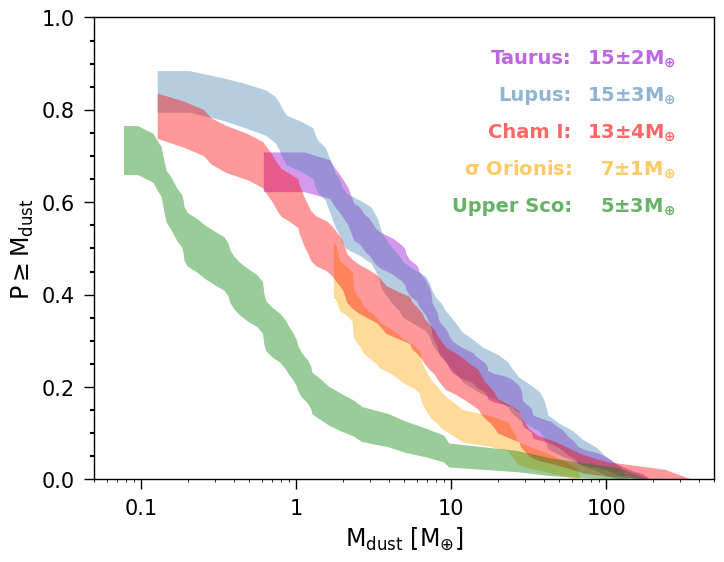

In [5]:
#### SETUP PLOT
plt.close('all')
mpl.rc('xtick',labelsize=15) 
mpl.rc('ytick',labelsize=15)
mpl.rc('xtick.major',size=7,pad=7,width=1)
mpl.rc('ytick.major',size=7,pad=7,width=1)
mpl.rc('axes',linewidth=1)
mpl.rc('lines',markersize=5)
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
xmin,xmax,ymin,ymax = 0.05,500,0,1.0
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
ax.set_xscale('log')
ax.set_ylabel(r'$\mathregular{P \geq M_{dust}}$',fontsize=17)
ax.set_xlabel(r'$\mathregular{M_{dust}}$'+' '+r'$\mathregular{[M_{\oplus}]}$',fontsize=17)
fig.canvas.draw()
labels = list(['','0.01','0.1','1','10','100'])
ax.set_xticklabels(labels)
ax.tick_params(which='minor',axis='y',length=3,color='k',width=1.5)
ax.minorticks_on()

#### PLOT REGIONS
ax.fill_between(np.append(kme_tau['bin_end'][0], kme_tau['bin_ctr'][1:]),
               np.append(kme_tau['kme'][1], kme_tau['kme'][1:]) - np.append(kme_tau['err'][1], kme_tau['err'][1:]),
               np.append(kme_tau['kme'][1], kme_tau['kme'][1:]) + np.append(kme_tau['err'][1], kme_tau['err'][1:]),
               facecolor='darkviolet', alpha=0.4, linewidth=0, edgecolor='darkviolet')
ax.text(60,0.90,'Taurus:',size=14,color='darkviolet',horizontalalignment='right',fontweight='bold',alpha=0.6)
ax.text(280,0.90,"{0:.0f}".format(float(mean_tau[0]))+r'$\mathregular{\pm}$'+ "{0:.0f}".format(float(mean_tau[1]))+r'$\mathregular{M_{\oplus}}$',
        size=14,color='darkviolet',horizontalalignment='right',fontweight='bold',alpha=0.6)

ax.fill_between(np.append(kme_lup['bin_end'][0], kme_lup['bin_ctr'][1:]),
               np.append(kme_lup['kme'][1], kme_lup['kme'][1:]) - np.append(kme_lup['err'][1], kme_lup['err'][1:]),
               np.append(kme_lup['kme'][1], kme_lup['kme'][1:]) + np.append(kme_lup['err'][1], kme_lup['err'][1:]),
               facecolor='steelblue', alpha=0.4, linewidth=0, edgecolor='steelblue')
ax.text(60,0.90-0.08,'Lupus:',size=14,color='steelblue',horizontalalignment='right',fontweight='bold',alpha=0.6)
ax.text(280,0.90-0.08,"{0:.0f}".format(float(mean_lup[0]))+r'$\mathregular{\pm}$'+ "{0:.0f}".format(float(mean_lup[1]))+r'$\mathregular{M_{\oplus}}$',
        size=14,color='steelblue',horizontalalignment='right',fontweight='bold',alpha=0.6)

ax.fill_between(np.append(kme_sor['bin_end'][0], kme_sor['bin_ctr'][1:]),
               np.append(kme_sor['kme'][1], kme_sor['kme'][1:]) - np.append(kme_sor['err'][1], kme_sor['err'][1:]),
               np.append(kme_sor['kme'][1], kme_sor['kme'][1:]) + np.append(kme_sor['err'][1], kme_sor['err'][1:]),
               facecolor='orange', alpha=0.4, linewidth=0.1, edgecolor='orange')
ax.text(60,0.90-3*0.08,r'$\mathregular{\sigma}$'+' Orionis'+':',size=14,color='orange',horizontalalignment='right',fontweight='bold',alpha=0.6)
ax.text(280,0.90-3*0.08,"{0:.0f}".format(float(mean_sor[0]))+r'$\mathregular{\pm}$'+ "{0:.0f}".format(float(mean_sor[1]))+r'$\mathregular{M_{\oplus}}$',
        size=14,color='orange',horizontalalignment='right',fontweight='bold',alpha=0.6)

ax.fill_between(np.append(kme_cha['bin_end'][0], kme_cha['bin_ctr'][1:]),
               np.append(kme_cha['kme'][1], kme_cha['kme'][1:]) - np.append(kme_cha['err'][1], kme_cha['err'][1:]),
               np.append(kme_cha['kme'][1], kme_cha['kme'][1:]) + np.append(kme_cha['err'][1], kme_cha['err'][1:]),
               facecolor='red', alpha=0.4, linewidth=0, edgecolor='red')
ax.text(60,0.90-2*0.08,'Cham I:',size=14,color='red',horizontalalignment='right',fontweight='bold',alpha=0.6)
ax.text(280,0.90-2*0.08,"{0:.0f}".format(float(mean_cha[0]))+r'$\mathregular{\pm}$'+ "{0:.0f}".format(float(mean_cha[1]))+r'$\mathregular{M_{\oplus}}$',
        size=14,color='red',horizontalalignment='right',fontweight='bold',alpha=0.6)

ax.fill_between(np.append(kme_usc['bin_end'][0], kme_usc['bin_ctr'][1:]),
               np.append(kme_usc['kme'][1], kme_usc['kme'][1:]) - np.append(kme_usc['err'][1], kme_usc['err'][1:]),
               np.append(kme_usc['kme'][1], kme_usc['kme'][1:]) + np.append(kme_usc['err'][1], kme_usc['err'][1:]),
               facecolor='green', alpha=0.4, linewidth=0, edgecolor='green')
ax.text(60,0.90-4*0.08,'Upper Sco:',size=14,color='green',horizontalalignment='right',fontweight='bold',alpha=0.6)
ax.text(280,0.90-4*0.08,"{0:.0f}".format(float(mean_usc[0]))+r'$\mathregular{\pm}$'+ "{0:.0f}".format(float(mean_usc[1]))+r'$\mathregular{M_{\oplus}}$',
        size=14,color='green',horizontalalignment='right',fontweight='bold',alpha=0.6)

In [6]:
fig.savefig('../output/figure_08.png', bbox_inches='tight', dpi=100)

### Linmix Version (approximate calculations)

In [7]:
#### LOAD IN TABLES 
# TL = Table.read('../output/data_lup.txt', format='ascii.ipac')
# TT = Table.read('../output/data_tau.txt', format='ascii.ipac')
# TU = Table.read('../output/data_usc.txt', format='ascii.ipac')
# TC = Table.read('../output/data_cha.txt', format='ascii.ipac')
# TS = Table.read('../output/data_sor.txt', format='ascii.ipac')

### REMOVE LUPUS UNKNOWN MASSES
# TL = TL[~TL['Mstar'].mask]

### GET KME 
# x_lup, y_lup, yl_lup, yu_lup = calc_KME('lup', TL['MDust'], TL['e_MDust'], TL['Det'])
# x_usc, y_usc, yl_usc, yu_usc = calc_KME('usc', TU['MDust'], TU['e_MDust'], TU['Det'])
# x_tau, y_tau, yl_tau, yu_tau = calc_KME('tau', TT['MDust'], TT['e_MDust'], TT['Det'])
# x_cha, y_cha, yl_cha, yu_cha = calc_KME('cha', TC['MDust'], TC['e_MDust'], TC['Det'])
# x_sor, y_sor, yl_sor, yu_sor = calc_KME('sor', TS['MDust'], TS['e_MDust'], TS['Det'])

### SETUP PLOT
# plt.close('all')
# mpl.rc('xtick', labelsize=15) 
# mpl.rc('ytick', labelsize=15)
# mpl.rc('xtick.major', size=7, pad=7, width=1)
# mpl.rc('ytick.major', size=7, pad=7, width=1)
# mpl.rc('xtick.minor', size=3, pad=7, width=1)
# mpl.rc('axes', linewidth=1)
# mpl.rc('lines', markersize=5)    
# fig = plt.figure(figsize = (8, 6))
# ax = fig.add_subplot(111)
# ax.set_xscale('log')
# ax.set_xlim(0.05,  500)
# ax.set_ylim(0,  1.0)
# ax.set_ylabel(r'$\mathregular{P \geq M_{dust}}$', fontsize=17)
# ax.set_xlabel(r'$\mathregular{M_{dust}}$' + ' ' + r'$\mathregular{[M_{\oplus}]}$', fontsize=17)
# fig.canvas.draw()
# labels = list(['0.1',  '1',  '10',  '100'])
# ax.set_xticks([0.1,  1.0,  10,  100])
# ax.set_xticklabels(labels)
# ax.minorticks_on()

### PLOT KME DISTRIBUTIONS
# ax.fill_between(x_tau, yl_tau, yu_tau, facecolor='purple', alpha=0.3, lw=0, label='Taurus')
# ax.fill_between(x_lup, yl_lup, yu_lup, facecolor='dodgerblue', alpha=0.3, lw=0, label='Lupus')
# ax.fill_between(x_cha, yl_cha, yu_cha, facecolor='red', alpha=0.3, lw=0, label='Cham I')
# ax.fill_between(x_sor, yl_sor, yu_sor, facecolor='orange', alpha=0.3, lw=0, label=r'$\mathregular{\sigma}$' + ' Orionis')
# ax.fill_between(x_usc, yl_usc, yu_usc, facecolor='green', alpha=0.3, lw=0, label='Upper Sco')
# ax.legend(loc=1,  prop={'size': 14})
# fig.savefig('../output/figure_08_linmix.pdf', bbox_inches='tight', dpi=100)